In [2]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.models import MultiClassLogistic, SLMMultiClassLogistic
from lenslessclass.datasets import MNISTAugmented
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from waveprop.devices import slm_dict, sensor_dict
import torchvision.datasets as dset
import matplotlib


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
linewidth = 3


models = {
    # # -- 784, 800 hidden
    # # "original_784_800": plib.Path("../MNIST_original_784dim_100epoch_seed0_SingleHidden800_09052022_15h42"),
    # # "lens_768_800": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_100epoch_seed0_SingleHidden800_09052022_16h20"),
    # # "lens_768_800": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_100epoch_seed0_SingleHidden800_10052022_22h28"),
    # "Lens": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_50epoch_seed0_SingleHidden800_10052022_23h56"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_00h14"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_11052022_17h10"),
    # # "Diffuser norm": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_17052022_23h01"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_11052022_17h25"),
    # # "Fixed SLM (m) norm": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_01h35"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_15052022_22h47"),
    # # "Fixed SLM (s) norm": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_01h56"),
    # # "fixed slm 1122 800": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_DeepBig3_15052022_19h16"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_11052022_08h41"),
    # # "Learned SLM 2": plib.Path("../MNIST_no_psf_down8_height0.12_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_18052022_08h08"),
    # # ADD MLS !!
    # # "MLS 63 0.004": plib.Path("../MNIST_simulated_mls63_mask2sensor0p004_17052022_18h01_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_00h53"),
    # # "MLS 127 0.0005": plib.Path("../MNIST_simulated_mls127_mask2sensor0p0005_17052022_17h58_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_00h33"),
    # # "MLS 127 0.004": plib.Path("../MNIST_simulated_mls127_mask2sensor0p004_17052022_18h08_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_01h13"),
    

    # "lens deep": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_50epoch_seed0_DeepBig6_14052022_11h31"),
    # "lens deep dropout 0.2": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_50epoch_seed0_DeepBig6_14052022_11h39"),
    # "diffuser_768_800_NONBN": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_SingleHidden800_09052022_17h27"),
    # "diffuser_768_800": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_50epoch_seed0_SingleHidden800_11052022_00h14"),
    # "diffuser_768_800_FULLRESSIM": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_100epoch_seed1_SingleHidden800_11052022_07h46"),
    # "fixed_slm_768_800_NONBN": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_SingleHidden800_09052022_16h51"),
    # "fixed_slm_768_800_FULLRESSIM": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_SingleHidden800_10052022_23h10"),
    # "fixed slm 800 800": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_DeepBig3_15052022_17h14"),
    # "fixed slm 800 400": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_DeepBig3_15052022_17h18"),
    # "learned_slm_768_800": plib.Path("../MNIST_no_psf_down8_outdim768_50epoch_seed1_logistic_reg_poisson40.0_DSresize_10052022_00h07"),
    # "learned_slm_768_800_OLD": plib.Path("../MNIST_no_psf_down8_outdim768_49epoch_seed1_SLMSingleHidden800_poisson40.0_DSresize_10052022_00h32"),
    # "learned_slm_768_800_fix40": plib.Path("../MNIST_no_psf_down8_outdim768_50epoch_seed1_SLMSingleHidden800_poisson40.0_DSresize_10052022_13h05"),
    # "learned_slm_768_800_fix25": plib.Path("../MNIST_no_psf_down8_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_10052022_15h23"),
    # "learned_slm_768_800_first50": plib.Path("../MNIST_no_psf_down8_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_10052022_21h54"),
    # "learned_slm_768_800_fix15": plib.Path("../MNIST_no_psf_down8_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_11052022_06h27"),

    # ## -- 192, 800 hidden
    # # "original_196_800": plib.Path("../MNIST_original_196dim_100epoch_seed0_SingleHidden800_09052022_19h44"),
    # # "lens_192_800_NONBN": plib.Path("../MNIST_lens_outdim192_height0.12_speckle40.0_croppsf100_100epoch_seed0_SingleHidden800_09052022_20h07"),
    # "Lens": plib.Path("../MNIST_lens_outdim192_height0.12_speckle40.0_croppsf100_50epoch_seed0_SingleHidden800_11052022_00h36"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_06h19"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_11052022_17h40"),
    # # "Diffuser norm": plib.Path("../MNIST_tape_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_05h42"),
    # # "Fixed SLM (m) norm": plib.Path("../MNIST_adafruit_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_05h55"),
    # # "Fixed SLM (s) norm": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_06h06"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_11052022_17h53"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_15052022_23h02"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_outdim192_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_11052022_19h27"),
    # # "diffuser_192_800_NONBN": plib.Path("../MNIST_tape_outdim192_height0.12_speckle40.0_100epoch_seed0_SingleHidden800_09052022_20h34"),
    # # "diffuser_192_800_FULLRESSIM": plib.Path("../MNIST_tape_outdim192_height0.12_speckle40.0_50epoch_seed0_SingleHidden800_11052022_01h03"),
    # # "fixed_slm_192_800_NONBN": plib.Path("../MNIST_adafruit_outdim192_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_SingleHidden800_09052022_22h28"),
    # # "fixed_slm_192_800_FULLRESSIM": plib.Path("../MNIST_adafruit_outdim192_height0.12_scene2mask0.4_poisson40.0_50epoch_seed0_SingleHidden800_11052022_00h49"),
    # # "learned_slm_192_800": plib.Path("../MNIST_no_psf_down8_outdim192_50epoch_seed1_SLMSingleHidden800_poisson40.0_DSresize_10052022_06h00"),

    # ## -- 48, 800 hidden
    # # "original_49_800": plib.Path("../MNIST_original_49dim_100epoch_seed0_SingleHidden800_09052022_18h03"),
    # # "lens_48_800_NONBN": plib.Path("../MNIST_lens_outdim48_height0.12_speckle40.0_croppsf100_100epoch_seed0_SingleHidden800_09052022_18h26"),
    # "Lens": plib.Path("../MNIST_lens_outdim48_height0.12_speckle40.0_croppsf100_50epoch_seed0_SingleHidden800_11052022_01h17"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_07h04"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_100epoch_seed0_SingleHidden800_11052022_15h13"),
    # # "Diffuser norm": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_06h31"),
    # # "Fixed SLM norm": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_06h42"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_11052022_18h19"),
    # # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_06h53"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_15052022_23h16"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_11052022_19h24"),
    # # "diffuser_48_800": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_50epoch_seed0_SingleHidden800_11052022_01h44"),
    # # "diffuser_48_800_NONBN": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_SingleHidden800_09052022_19h18"),
    # # "diffuser_48_800_down8_avg": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_DSavg_100epoch_seed0_SingleHidden800_11052022_15h34"),
    # # "fixed_slm_48_800_NONBN": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_SingleHidden800_09052022_18h52"),
    # # "fixed_slm_48_800_FULLRESSIM": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_50epoch_seed0_SingleHidden800_11052022_01h30"),
    # # "fixed slm deep": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_DeepBig6_14052022_11h02"),
    # # "fixed slm deep dropout": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_DeepBig6_14052022_11h21"),
    # # "learned_slm_48_800_OLD": plib.Path("../MNIST_no_psf_down8_outdim48_50epoch_seed1_SLMSingleHidden800_poisson40.0_DSresize_10052022_12h08"),
    # # "learned_slm_48_800": plib.Path("../MNIST_no_psf_down8_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_11052022_10h00"),
    # # "learned_slm_48_800_avg": plib.Path("../MNIST_no_psf_down8_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSavg_11052022_13h33"),

    # ## -- 12, 800 hidden
    # "Lens": plib.Path("../MNIST_lens_outdim12_height0.12_scene2mask0.4_poisson40.0_croppsf100_50epoch_seed0_SingleHidden800_13052022_06h07"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_07h49"),
    # # "Diffuser norm": plib.Path("../MNIST_tape_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_07h16"),
    # # "Fixed SLM norm": plib.Path("../MNIST_adafruit_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_07h27"),
    # # "Fixed SLM (sim.) norm": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_17052022_23h53"),
    # # "Fixed SLM (sim.)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_07h38"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_17052022_23h31"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_12052022_12h03"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_15052022_23h30"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_outdim12_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_12052022_12h21"),
    # # "Diffuser": plib.Path("../MNIST_tape_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_12052022_11h51"),

    # ## -- 48
    # # "original_49": plib.Path("../models/MNIST_original_49dim_100epoch_seed0_MultiClassLogistic_04052022_01h16"),
    # "Lens": plib.Path("../models/MNIST_lens_outdim48_height0.12_speckle40.0_croppsf100_100epoch_seed0_MultiClassLogistic_04052022_02h45"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_04h42"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_04h03"),
    # # "Fixed SLM": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_11052022_16h58"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_04h16"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_04h29"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_outdim48_100epoch_seed0_logistic_reg_speckle40.0_04052022_15h04"),
    # # "diffuser_48_speckle": plib.Path("../models/MNIST_tape_outdim48_height0.12_speckle40.0_100epoch_seed0_MultiClassLogistic_04052022_12h57"),
    # # "Diffuser": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_11052022_16h42"),
    # # "diffuser_48_FULLRESSIM": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_MultiClassLogistic_05052022_21h52"),
    # # "Fixed SLM (sim.)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_15052022_22h14"),
    # # "fixed_slm_48_FULLRESSIM": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_MultiClassLogistic_07052022_13h58"),
    # # "learned_slm_48_1": plib.Path("../MNIST_no_psf_down8_outdim48_100epoch_seed0_logistic_reg_poisson40.0_DSresize_08052022_20h19"),
    # # "learned_slm_48_2": plib.Path("../MNIST_no_psf_down8_outdim48_100epoch_seed0_logistic_reg_poisson40.0_DSresize_08052022_22h34"),

    # ## -- 12
    # "Lens": plib.Path("../MNIST_lens_outdim12_height0.12_scene2mask0.4_poisson40.0_croppsf100_50epoch_seed0_MultiClassLogistic_12052022_20h28"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_05h32"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_04h52"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_05h06"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_05h19"),
    # # "Fixed SLM": plib.Path("../MNIST_adafruit_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_12052022_20h51"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_outdim12_50epoch_seed0_SLMMultiClassLogistic_poisson40.0_DSresize_12052022_21h03"),
    # # "Diffuser": plib.Path("../MNIST_tape_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_12052022_20h40"),
    # # "Fixed SLM (sim.)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim12_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_15052022_22h35"),

    # # # # -- 784
    # # "original_784": plib.Path("../models/MNIST_original_100epoch_seed0_logistic_reg_22042022_15h25"),
    # "Lens": plib.Path("../models/MNIST_lens_outdim768_height0.12_speckle40.0_croppsf100_200epoch_seed0_logistic_reg_29042022_18h21"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_02h51"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_02h13"),
    # # "diffuser_768_speckle": plib.Path("../models/MNIST_tape_outdim768_height0.12_speckle40.0_200epoch_seed0_logistic_reg_29042022_19h13"),
    # # "diffuser_768_down_1": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_MultiClassLogistic_07052022_15h33"),
    # # "diffuser_768_FULLRESSIM": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_100epoch_seed0_MultiClassLogistic_07052022_21h24"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_02h26"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_02h39"),
    # # "Fixed SLM": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_11052022_15h54"),
    # # "fixed_slm_768_FULLRESSIM": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_MultiClassLogistic_07052022_14h07"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_outdim768_72epoch_seed1_logistic_reg_poisson40.0_DSresize_09052022_17h39"),
    # # "Diffuser": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_11052022_16h09"),
    # # "Fixed SLM (sim.)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_15052022_21h34"),
    # # "MLS 63 0.0005": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_17052022_21h27"),
    # # "MLS 127 0.0005": plib.Path("../MNIST_simulated_mls127_mask2sensor0p0005_17052022_17h58_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_17052022_21h44"),
    # # "MLS 63 0.004": plib.Path("../MNIST_simulated_mls63_mask2sensor0p004_17052022_18h01_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_17052022_22h00"),
    # # "MLS 127 0.0005": plib.Path("../MNIST_simulated_mls127_mask2sensor0p004_17052022_18h08_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_17052022_22h16"),
    
    # "fixed slm (no deadspace)": plib.Path("../MNIST_simulated_adafruit_deadspaceFalse_15052022_21h44_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_15052022_22h09"),
    # "learned_slm_713": plib.Path("../models/MNIST_no_psf_down8_outdim713_100epoch_seed0_logistic_reg"),
    # "learned_slm_768_0": plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed0_logistic_reg_poisson40.0_05052022_23h48"),
    # # training/test images went below 0...
    # "learned_slm_768_BAD": plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed1_logistic_reg_poisson40.0_06052022_00h23"),
    # "tape_batch32": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_11052022_21h44"),
    # "learned_slm_768_quant": plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed1_logistic_reg_poisson40.0_DSresize_09052022_02h16"),
    # "learned_slm_768_avg": plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed1_logistic_reg_poisson40.0_DSavg_09052022_09h59"),
    # "learned_slm_768_resize": plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed1_logistic_reg_poisson40.0_DSresize_09052022_10h39"),
    # "clamp": plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed1_logistic_reg_poisson40.0_DSresize_09052022_11h47"),
    # "sub_min": plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed1_logistic_reg_poisson40.0_DSresize_09052022_12h26"),
    # "learned_slm_768_max": plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed1_logistic_reg_poisson40.0_DSmax_06052022_15h02"),
    # "learned_slm_384": plib.Path("../models/MNIST_no_psf_down8_outdim374_91epoch_seed0_logistic_reg_speckle40.0_02052022_11h53"),

    # # -- 192
    # # "original_196": plib.Path("../models/MNIST_original_196dim_100epoch_seed0_MultiClassLogistic_04052022_00h57"),
    # "Lens": plib.Path("../models/MNIST_lens_outdim192_height0.12_speckle40.0_croppsf100_100epoch_seed0_MultiClassLogistic_04052022_05h55"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_03h48"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_03h06"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_03h20"),
    # # "Fixed SLM": plib.Path("../MNIST_adafruit_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_11052022_17h26"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_03h34"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_outdim192_50epoch_seed0_SLMMultiClassLogistic_poisson40.0_DSresize_10052022_09h11"),
    # # "diffuser_192_FULLRESSIM": plib.Path("../models/MNIST_tape_outdim192_height0.12_speckle40.0_100epoch_seed0_MultiClassLogistic_04052022_07h35"),
    # # "Diffuser old": plib.Path("../MNIST_tape_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_11052022_16h29"),
    # # "Diffuser norm": plib.Path("../MNIST_tape_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_18052022_03h06"),
    # # "fixed_slm_192_FULLRESSIM": plib.Path("../MNIST_adafruit_outdim192_height0.12_scene2mask0.4_poisson40.0_100epoch_seed0_MultiClassLogistic_07052022_13h31"),
    # # "Fixed SLM (sim.)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim192_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_MultiClassLogistic_15052022_21h53"),
    # # "learned_slm_192_BAD": plib.Path("../models/MNIST_no_psf_down8_outdim192_100epoch_seed0_logistic_reg_speckle40.0_03052022_12h20"),



    # "original_400": plib.Path("../models/MNIST_original_400dim_100epoch_seed0_MultiClassLogistic_04052022_00h38"),
    
    
    # 5 cm
    # "lens": plib.Path("../MNIST_lens_down128_100epoch_logistic_reg"),
    # "tape": plib.Path("../MNIST_tape_down128_100epoch_logistic_reg"),
    # "learned_slm": plib.Path("../MNIST_no_psf_down8_100epoch_logistic_reg"),
    # 12 cm
    # "lens_12cm": plib.Path("../MNIST_lens_down128_height0.12_100epoch_seed0_logistic_reg_27042022_12h28"),
    # "lens_12cm_200": plib.Path("../MNIST_lens_down128_height0.12_200epoch_seed0_logistic_reg_28042022_09h20"),
    # "lens_12cm_500": plib.Path("../MNIST_lens_outdim784_height0.12_500epoch_seed0_logistic_reg_27042022_23h11"),
    
    # # fixed lens (less noisy output)
    # "lens_12cm_100": plib.Path("../MNIST_lens_outdim768_height0.12_croppsf100_100epoch_seed0_logistic_reg_29042022_14h33"),
    # "tape_12cm": plib.Path("../MNIST_lens_down128_height0.12_100epoch_seed0_logistic_reg_27042022_12h28"),
    # # "tape_12cm_200": plib.Path("../MNIST_tape_down128_height0.12_200epoch_seed0_logistic_reg_28042022_11h38"),
    # "learned_slm_12cm": plib.Path("../MNIST_no_psf_down8_height0.12_100epoch_seed0_logistic_reg"),

    # with speckle noise
    # "lens_384": plib.Path("../models/MNIST_lens_outdim374_height0.12_speckle40.0_croppsf100_100epoch_seed0_MultiClassLogistic_04052022_09h08"),

    # "tape_384": plib.Path("../models/MNIST_tape_outdim374_height0.12_speckle40.0_100epoch_seed0_MultiClassLogistic_04052022_10h50"),
    # "tape_48_2": plib.Path("../models/MNIST_tape_outdim48_height0.12_speckle40.0_100epoch_seed0_MultiClassLogistic_04052022_04h24"),



    # ## RANDOM SHIFT
    # # # # 6x8, hidden 800, shifted
    # # "Lens": plib.Path("../MNIST_lens_outdim48_height0.12_scene2mask0.4_poisson40.0_croppsf100_RandomShift_50epoch_seed0_SingleHidden800_14052022_14h31"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_18052022_11h45"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_13052022_13h05"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_13052022_13h11"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_16052022_18h54"),
    # # "learned slm shift": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_13052022_13h26"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim48_5epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_14052022_21h09"),
    # # "learned slm 48 3": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_14052022_00h33"),

    # "Lens": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_RandomShift_50epoch_seed0_SingleHidden800_14052022_00h18"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_18052022_03h46"),
    # # "lens 768 deep": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_RandomShift_50epoch_seed0_DeepBig6_14052022_11h42"),
    # # "diffuser": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_13052022_13h24"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_18052022_01h20"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_18052022_03h29"),
    # # "fixed slm 768": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_13052022_13h36"),
    # # "fixed slm deep": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_DeepBig6_14052022_11h59"),
    # # "fixed slm sim": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_16052022_17h52"),
    # # "Fixed SLM (sim.)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_16052022_17h52"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_18052022_03h13"),
    # # "fixed slm sim": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_18052022_03h13"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_13052022_13h54"),

    # ### RESCALE
    # # # 24 x 32, 768
    "Lens": plib.Path("../MNIST_lens_outdim768_height0.02-0.2_scene2mask0.4_poisson40.0_croppsf100_50epoch_seed0_SingleHidden800_19052022_00h31"),
    "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim768_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_04h35"),
    "Diffuser": plib.Path("../MNIST_tape_outdim768_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_19052022_02h06"),
    # "Diffuser norm": plib.Path("../MNIST_tape_outdim768_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_04h51"),
    # # "diffuser": plib.Path("../MNIST_tape_outdim768_height0.05-0.15_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_16052022_19h10"),
    # # "fixed slm": plib.Path("../MNIST_adafruit_outdim768_height0.05-0.15_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_16052022_19h29"),
    # "Fixed SLM (m) norm": plib.Path("../MNIST_adafruit_outdim768_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_04h19"),
    # "Fixed SLM (s) norm": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_04h02"),
    # # "fixed slm sim": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.05-0.15_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_16052022_19h47"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.05-0.15_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_17052022_00h08"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.02-0.2_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_17052022_16h15"),
    "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim768_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_19052022_01h33"),
    "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_19052022_00h54"),
    "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.02-0.2_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_18052022_23h33"),
    

    # # 6x8, 
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim48_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_18052022_11h56"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim48_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_14052022_14h37"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim48_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed0_SingleHidden800_14052022_14h03"),

    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.02-0.2_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed1_SingleHidden800_17052022_06h57"),
    # # "fixed slm sim 01": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.05-0.15_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed1_SingleHidden800_16052022_23h59"),
    # # "fixed slm sim 11": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.05-0.15_scene2mask0.4_poisson40.0_downpsf8.0_50epoch_seed1_SingleHidden800_17052022_00h29"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.02-0.2_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_14052022_14h58"),

    # ROTATE
    # # -- 768
    # "Lens": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_RandomRotate90.0_50epoch_seed0_SingleHidden800_17052022_12h59"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_18052022_06h06"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_16052022_20h25"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_16052022_20h46"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_16052022_21h08"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.12_RandomRotate90.0_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_17052022_08h39"),

    # norm
    # "Diffuser": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_18052022_05h10"),
    # "Fixed SLM": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_18052022_05h29"),
    # "Fixed SLM (sim.)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_18052022_05h47"),
    

    # # -- 48
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_18052022_12h07"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_14052022_22h08"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_14052022_22h08"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomRotate90.0_50epoch_seed0_SingleHidden800_16052022_21h29"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.12_RandomRotate90.0_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_14052022_22h29"),

    # #PERSPECTIVE
    # # #  - 768 
    # "Lens": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_RandomPerspective0.5_50epoch_seed0_SingleHidden800_17052022_14h09"),
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_18052022_07h24"),
    # # "Diffuser (meas)": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_18052022_06h26"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_16052022_21h50"),
    # # "Fixed SLM (meas)": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_18052022_06h45"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_16052022_22h12"),
    # # "Fixed SLM (sim)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_18052022_07h05"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_16052022_22h34"),
    # # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.12_RandomPerspective0.5_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_17052022_16h06"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.12_RandomPerspective0.5_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_18052022_14h34")

    # #- 48
    # "CA": plib.Path("../MNIST_simulated_mls63_mask2sensor0p0005_17052022_18h00_12bit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_18052022_12h18"),
    # "Diffuser": plib.Path("../MNIST_tape_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_15052022_01h35"),
    # "Fixed SLM (m)": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_15052022_01h34"),
    # "Fixed SLM (s)": plib.Path("../MNIST_simulated_adafruit_deadspaceTrue_15052022_21h04_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomPerspective0.5_50epoch_seed0_SingleHidden800_16052022_23h07"),
    # "Learned SLM": plib.Path("../MNIST_no_psf_down8_height0.12_RandomPerspective0.5_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_15052022_01h26"),


    # # # # varying size for shifting, to see when enough pixels as caught
    # "lens 768": plib.Path("../MNIST_lens_outdim768_height0.12_scene2mask0.4_poisson40.0_croppsf100_RandomShift_50epoch_seed0_SingleHidden800_14052022_00h18"),
    # "fixed 48": plib.Path("../MNIST_adafruit_outdim48_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_13052022_13h11"),
    # "fixed 768": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_13052022_13h36"),
    # "fixed 768 deep": plib.Path("../MNIST_adafruit_outdim768_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_DeepBig3_15052022_17h11"),
    # # "fixed 3072": plib.Path("../MNIST_adafruit_outdim3072_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_20epoch_seed0_SingleHidden800_15052022_06h49"),
    # "fixed 3072": plib.Path("../MNIST_adafruit_outdim3072_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_SingleHidden800_15052022_15h31"),
    # # "fixed 3072 deep": plib.Path("../MNIST_adafruit_outdim3072_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_50epoch_seed0_DeepBig6_15052022_16h57"),
    # "fixed 11224": plib.Path("../MNIST_adafruit_outdim11224_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_20epoch_seed0_SingleHidden800_15052022_07h07"),
    # # "fixed 42364": plib.Path("../MNIST_adafruit_outdim42364_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_20epoch_seed0_SingleHidden800_15052022_07h32"),
    # # "fixed 192600": plib.Path("../MNIST_adafruit_outdim192660_height0.12_scene2mask0.4_poisson40.0_downpsf8.0_RandomShift_20epoch_seed0_SingleHidden800_15052022_08h22"),

    # # "learned 12": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim12_5epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_15052022_09h33"),
    # "learned 48": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim48_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_14052022_00h33"),
    # "learned 768": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_13052022_13h54"),
    # # "learned 3072": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim3072_5epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_15052022_13h02"),
    # "learned 3072": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim3072_45epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_15052022_15h53"),
    # "learned 3072 dropout": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim3072_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_15052022_20h07"),
    # "learned 11224": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim11224_5epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_15052022_13h38"),
    # # "learned 42364": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim42364_5epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_15052022_14h15"),
    # # "learned 192600": plib.Path("../MNIST_no_psf_down8_height0.12_RandomShift_outdim192660_5epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_15052022_14h55"),
}

markers_dict = {
    "Lens": "o",
    "CA": "s",
    "Diffuser": "X",
    "Fixed SLM (m)": "^",
    "Fixed SLM (s)": "v",
    "Learned SLM": "D",
}
color_dict = {
    "Lens": "darkorange",
    "CA": "red",
    "Diffuser": "deeppink",
    "Fixed SLM (m)": "purple",
    "Fixed SLM (s)": "blue",
    "Learned SLM": "g",
}

markers = ["o", "s", "D", "P", "X", "v",  "<", ">", "D", ".", "1", "2", "3", "4", "8"]
linestyles = ["solid", "dotted", "dashed", "dashdot", (0, (3, 1, 1, 1, 1, 1))]

Lens : 0.40339149534702307
CA : 0.41076236605644223
Diffuser : 0.4237086331844329
Fixed SLM (m) : 0.41055919945240016
Fixed SLM (s) : 0.40581635773181907
Learned SLM : 0.3864404195547104


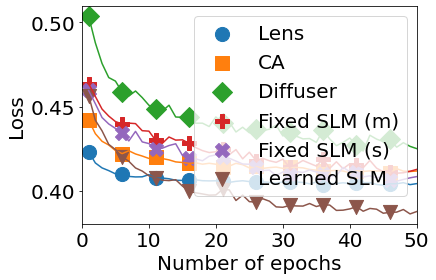

In [3]:
# load and plot error plots
for i, m in enumerate(models.keys()):
    test_loss = np.load(str(models[m] / "test_loss.npy"))
    n_epoch = np.arange(len(test_loss)) + 1
    print(f"{m} : {np.min(test_loss)}")
    plt.plot(n_epoch,  test_loss)
    plt.scatter(n_epoch[::5], test_loss[::5], marker=markers[i], label=m, s=markersize)
plt.legend()
plt.ylabel("Loss")
plt.xlim([0, 50])
plt.xlabel("Number of epochs");

Lens : 0.8481999635696411
CA : 0.8208000063896179
Diffuser : 0.777999997138977
Fixed SLM (m) : 0.8303999900817871
Fixed SLM (s) : 0.8432999849319458
Learned SLM : 0.9196999669075012


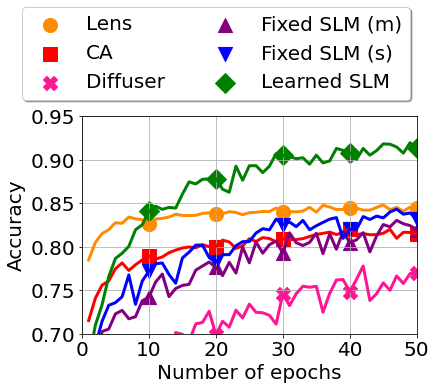

In [6]:
MAX_EPOCH = 50
markersize = 200
every = 10

ax = plt.subplot(111)
for i, m in enumerate(models.keys()):
    test_acc = np.load(str(models[m] / "test_acc.npy"))
    # print(len(test_acc))
    n_epoch = np.arange(len(test_acc)) + 1
    print(f"{m} : {np.max(test_acc[:MAX_EPOCH])}")
    ax.plot(n_epoch,  test_acc, linewidth=linewidth, linestyle="-", c=color_dict[m])
    ax.scatter(n_epoch[9::every], test_acc[9::every], marker=markers_dict[m], label=m, s=markersize, c=color_dict[m])

    # ax.plot(n_epoch,  test_acc, linewidth=linewidth, linestyle=linestyles[i], label=m,)
    # ax.plot(n_epoch,  test_acc, linewidth=linewidth, label=m,)

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.xlim([0, MAX_EPOCH]);
plt.ylim([0.7, 0.95])   # 192
plt.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.4, 1.55),
          ncol=2, fancybox=True, shadow=True)



# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2.2),
#           ncol=2, fancybox=True, shadow=True)
# plt.ylim([0.2, 1.0])   # 768

TypeError: len() of unsized object

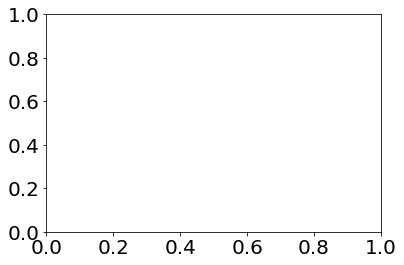

In [231]:
MAX_EPOCH = 50

ax = plt.subplot(111)
for i, m in enumerate(models.keys()):
    try:
        test_acc = np.load(str(models[m] / "train_acc.npy"))
    except:
        continue
    # print(m)
    # print(len(test_acc))
    n_epoch = np.arange(len(test_acc)) + 1
    print(f"{m} : {np.max(test_acc[:MAX_EPOCH])}")
    ax.plot(n_epoch,  test_acc, linewidth=linewidth)
    ax.scatter(n_epoch[::5], test_acc[::5], marker=markers[i], label=m, s=markersize)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.xlim([0, MAX_EPOCH]);
plt.ylim([0.2, 1.0])   # 48
plt.ylim([0.2, 0.9])   # 768
# plt.ylim([0.9, 1.0])   # 192
plt.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
          ncol=2, fancybox=True, shadow=True)



ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2.2),
          ncol=2, fancybox=True, shadow=True)
# plt.ylim([0.2, 1.0])   # 768

# Confusion matrix on test set

In [1]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.models import MultiClassLogistic, SLMMultiClassLogistic
from lenslessclass.datasets import MNISTAugmented
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from waveprop.devices import slm_dict, sensor_dict
import torchvision.datasets as dset
import matplotlib


# model_dir = models["lens"]
# model_dir = models["tape"]
# model_dir = models["original"]
# model_dir = models["learned_slm_713"]

model_dir = plib.Path("../MNIST_no_psf_down8_outdim768_100epoch_seed1_logistic_reg_poisson40.0_06052022_00h23")
# model_dir = plib.Path("../models/MNIST_no_psf_down8_outdim192_100epoch_seed0_logistic_reg_speckle40.0_03052022_12h20")
# model_dir = plib.Path("../MNIST_no_psf_down8_outdim48_100epoch_seed0_logistic_reg_speckle40.0_04052022_15h04")
model_dir = plib.Path("../MNIST_no_psf_down8_outdim768_50epoch_seed0_SLMSingleHidden800_poisson40.0_DSresize_11052022_08h41")


In [2]:
# Opening JSON file
f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
pprint(metadata)

{'batch_size': 200,
 'best_test_acc': 0.9797999858856201,
 'best_test_acc_epoch': 23,
 'dataset': '/home/bezzam/LenslessClassification/data/MNIST_no_psf_down8',
 'down_orig': 1.0,
 'mean': 0.0010810066014528275,
 'min_val': -0.037515487521886826,
 'model': 'SLMSingleHidden800',
 'model_param': {'crop_fact': 0.8,
                 'deadspace': True,
                 'device': 'cuda:0',
                 'device_mask_creation': 'cpu',
                 'down': 'resize',
                 'dropout': None,
                 'hidden': 800,
                 'input_shape': [380, 507],
                 'mask2sensor': 0.004,
                 'multi_gpu': True,
                 'scene2mask': 0.4,
                 'target_dim': [28, 28]},
 'noise_type': 'poisson',
 'seed': 0,
 'sensor': 'rpi_hq',
 'sensor_activation': 'relu',
 'slm': 'adafruit',
 'snr': 40.0,
 'std': 0.02881494164466858}


In [3]:
# load test set
if metadata["dataset"]:

    # if metadata["model"] == "SLMMultiClassLogistic":
    #     # hybrid
    #     trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
    #     test_set = MNISTAugmented(path=metadata["dataset"], train=False, transform=trans)
    # else:
    #     trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
    #     test_set = MNISTAugmented(path=metadata["dataset"], train=False, transform=trans)

    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
    test_set = MNISTAugmented(path=metadata["dataset"], train=False, transform=trans)

else:
    root = "../data"
    trans = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((metadata["mean"],), (metadata["std"],))]
    )
    test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=metadata["batch_size"], shuffle=False
)

In [4]:
# create model instance
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")

if metadata["model"] == "SLMMultiClassLogistic" or "SLMSingleHidden" in metadata["model"]:
    sensor_act_fn = None
    sensor_act = metadata["sensor_activation"]
    if sensor_act is not None:
        if sensor_act == "relu":
            sensor_act_fn = nn.ReLU()
        elif sensor_act == "leaky":
            sensor_act_fn = nn.LeakyReLU(float=0.1)
        elif sensor_act == "tanh":
            sensor_act_fn = nn.Tanh()
        else:
            raise ValueError("Not supported activation.")

    metadata["model_param"].update(
        {
            "slm_config": slm_dict[metadata["slm"]],
            "sensor_config": sensor_dict[metadata["sensor"]],
            "sensor_activation": sensor_act_fn,
            "n_class": 10,
            "multi_gpu": [0, 1]    # FIX
        }
    )
    model = SLMMultiClassLogistic(**metadata["model_param"])
elif metadata["model"] == "MultiClassLogistic":
    model = MultiClassLogistic(**metadata["model_param"])
else:
    raise ValueError("Unsupported model.")

if use_cuda:
    model = model.to(device)

# -- load from state dict
state_dict_fp = str(model_dir / "state_dict.pth")
model.load_state_dict(torch.load(state_dict_fp))

if metadata["model"] == "SLMMultiClassLogistic" or "SLMSingleHidden" in metadata["model"]:
    # recompute PSF for loaded SLM values
    model.compute_intensity_psf()

CUDA available, using GPU.


In [5]:
print("\nModel's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
slm_vals 	 torch.Size([51, 22])
conv_bn.module.weight 	 torch.Size([1])
conv_bn.module.bias 	 torch.Size([1])
conv_bn.module.running_mean 	 torch.Size([1])
conv_bn.module.running_var 	 torch.Size([1])
conv_bn.module.num_batches_tracked 	 torch.Size([])
linear1.module.weight 	 torch.Size([800, 768])
bn.module.weight 	 torch.Size([800])
bn.module.bias 	 torch.Size([800])
bn.module.running_mean 	 torch.Size([800])
bn.module.running_var 	 torch.Size([800])
bn.module.num_batches_tracked 	 torch.Size([])
linear2.module.weight 	 torch.Size([10, 800])
linear2.module.bias 	 torch.Size([10])


In [6]:
criterion = nn.CrossEntropyLoss()

y_pred = []
y_true = []
correct_cnt, running_loss = 0, 0
total_cnt = 0
for x, target in test_loader:

    # get inputs
    if use_cuda:
        x, target = x.cuda(), target.cuda()

    x -= metadata["min_val"]

    # forward, and compute loss
    out = model(x)
    loss = criterion(out, target)
    pred_label = torch.max(out.data, 1)[1]
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    running_loss += loss.item() / metadata["batch_size"]

    # save prediction and true for confusion matrix
    y_pred.extend(pred_label.data.cpu().numpy()) # Save Prediction
    y_true.extend(target.data.cpu().numpy())

acc = (correct_cnt * 1.0 / total_cnt).item()
print("test loss: {:.6f}, acc: {:.3f}".format( running_loss, acc))
print('Class distribution: %s' % np.bincount(y_true))

test loss: 0.370480, acc: 0.980
Class distribution: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


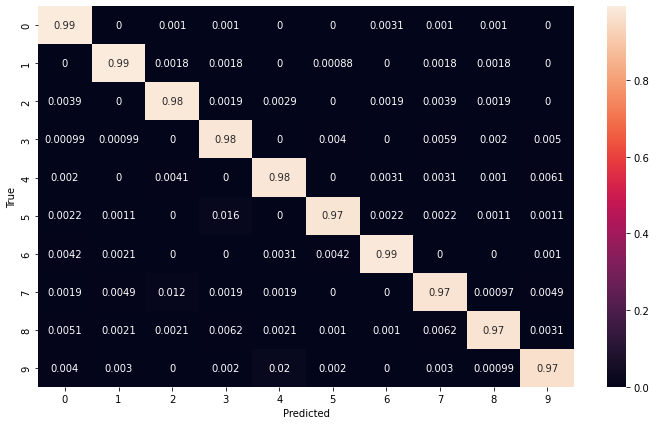

In [7]:
# Build confusion matrix
classes = np.arange(10)
cf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.ylabel("True")
plt.xlabel("Predicted");